Epoch 1/30, Train Loss: 3.2319, Train Acc: 8.66%, Val Loss: 2.7605, Val Acc: 18.10%
Epoch 2/30, Train Loss: 2.5119, Train Acc: 25.21%, Val Loss: 2.1058, Val Acc: 34.77%
Epoch 3/30, Train Loss: 2.1282, Train Acc: 35.01%, Val Loss: 1.8319, Val Acc: 43.16%
Epoch 4/30, Train Loss: 1.8913, Train Acc: 41.73%, Val Loss: 1.6514, Val Acc: 47.42%
Epoch 5/30, Train Loss: 1.7278, Train Acc: 46.63%, Val Loss: 1.5424, Val Acc: 50.81%
Epoch 6/30, Train Loss: 1.6151, Train Acc: 49.86%, Val Loss: 1.4184, Val Acc: 55.23%
Epoch 7/30, Train Loss: 1.5286, Train Acc: 51.96%, Val Loss: 1.4014, Val Acc: 56.87%
Epoch 8/30, Train Loss: 1.4569, Train Acc: 54.47%, Val Loss: 1.3092, Val Acc: 58.35%
Epoch 9/30, Train Loss: 1.3894, Train Acc: 56.23%, Val Loss: 1.2027, Val Acc: 61.03%
Epoch 10/30, Train Loss: 1.3407, Train Acc: 57.62%, Val Loss: 1.2438, Val Acc: 61.42%
Epoch 11/30, Train Loss: 1.2980, Train Acc: 59.19%, Val Loss: 1.1523, Val Acc: 62.55%
Epoch 12/30, Train Loss: 1.2537, Train Acc: 60.63%, Val Loss: 1.

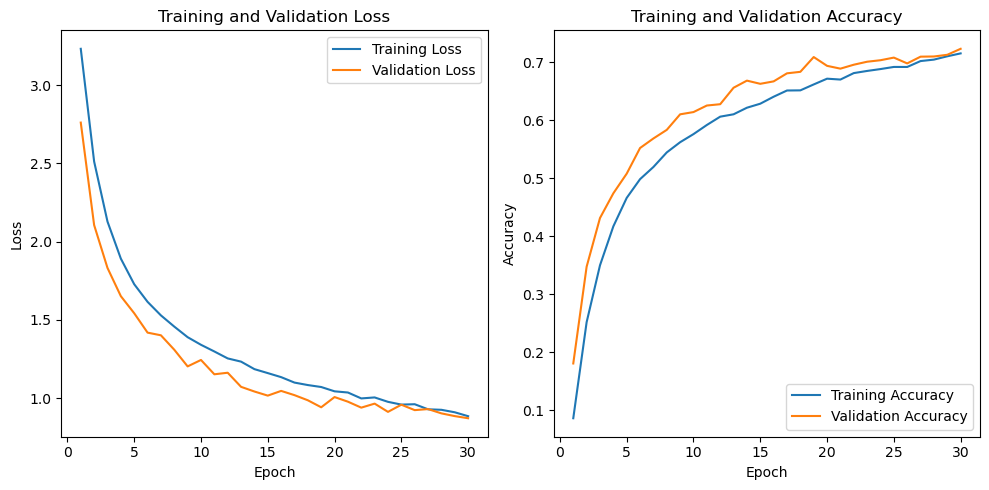

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import cv2
import matplotlib.pyplot as plt

class ImageDataset(Dataset):
    def __init__(self, directory, labels, transform=None):
        self.directory = directory
        self.labels = labels
        self.transform = transform
        self.data = []
        self.load_dataset()

    def load_dataset(self):
        for idx, label in enumerate(self.labels):
            path = os.path.join(self.directory, label)
            files = os.listdir(path)
            for file in files:
                img_path = os.path.join(path, file)
                img = cv2.resize(cv2.imread(img_path), (50, 50))
                self.data.append((img, idx))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),      # Data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = r"C:\Users\rasha\Downloads\augmented_arabic_sign_language_dataset_small"
uniq_labels = sorted(os.listdir(data_dir))
dataset = ImageDataset(data_dir, uniq_labels, transform)
train_size = int(0.8 * len(dataset))
validation_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class ConvNet(nn.Module):

    def __init__(self):

        super(ConvNet, self).__init__()

        self.layer1 = nn.Sequential(

            nn.Conv2d(3, 16, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.BatchNorm2d(16),  # Batch normalization

            nn.Conv2d(16, 16, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.25))  # Dropout

        self.layer2 = nn.Sequential(

            nn.Conv2d(16, 32, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Dropout(0.25))

        self.layer3 = nn.Sequential(

            nn.Conv2d(32, 64, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.BatchNorm2d(64),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),

            nn.ReLU(),

            nn.Dropout(0.25))

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(64*12*12, 128)

        self.fc2 = nn.Linear(128, len(uniq_labels))

 
    def forward(self, x):

        x = self.layer1(x)

        x = self.layer2(x)

        x = self.layer3(x)

        x = self.flatten(x)

        x = self.fc1(x)

        x = self.fc2(x)

        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


num_epochs = 30

# Training the model
def train_model(model, train_loader, validation_loader, num_epochs=20):
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct, total_samples = 0, 0, 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        train_losses.append(total_loss / len(train_loader))
        train_accs.append(total_correct / total_samples)

        # Validation phase
        model.eval()
        val_loss, val_correct, val_samples = 0, 0, 0
        with torch.no_grad():
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_samples += labels.size(0)

        val_losses.append(val_loss / len(validation_loader))
        val_accs.append(val_correct / val_samples)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accs[-1]*100:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accs[-1]*100:.2f}%')

    return train_losses, train_accs, val_losses, val_accs


train_losses, train_accs, val_losses, val_accs = train_model(model, train_loader, validation_loader, num_epochs)

# Plotting the training and validation statistics
import matplotlib.pyplot as plt
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Training Accuracy')
plt.plot(epochs, val_accs, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
torch.save(model.state_dict(), 'model_best_arabic_after_augmantation.ckpt')
